In [1]:
import os
import random
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
from tqdm import tqdm
import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.optimizers import Adam

print("TensorFlow version:", tf.__version__)


2025-10-30 01:07:52.878553: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1761786473.149633      19 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1761786473.219949      19 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


TensorFlow version: 2.18.0


## Base paths and variables

In [2]:
BRAND = "BMW" 
IMG_SIZE = (256, 256) 
BATCH_SIZE = 32
TOTAL_POSITIVE = 1000
TOTAL_NEGATIVE = 1000
SPLIT_RATIOS = {'train': 0.7, 'val': 0.15, 'test': 0.15}

logo_dir = '/kaggle/input/logo-dataset-2341-classes-and-167140-images/datasetcopy/trainandtest/train/Transportation/BMW'       
background_dir = '/kaggle/input/stanford-background-dataset/images'                
dataset_dir = '/kaggle/working/dataset'                
video_path = '/kaggle/input/lab6video/StockFootage.mp4'
save_model_dir = '/kaggle/working/model'      


## Data generation

In [3]:
for split in ['train','val','test']:
    for cls in ['positive','negative']:
        os.makedirs(os.path.join(dataset_dir, split, cls), exist_ok=True)

def augment_logo(logo):
    angle = random.uniform(-30, 30)
    logo = logo.rotate(angle, expand=True)
    scale = random.uniform(0.5, 1.5)
    w, h = logo.size
    logo = logo.resize(
    (max(1, int(w * scale)), max(1, int(h * scale))),Image.Resampling.LANCZOS)
    if logo.mode != 'RGBA':
        logo = logo.convert('RGBA')
    alpha = random.uniform(0.5, 1.0)
    a = logo.split()[-1].point(lambda p: int(p * alpha))
    logo.putalpha(a)
    return logo

logo_files = [os.path.join(logo_dir, f) for f in os.listdir(logo_dir) if f.lower().endswith(('.png','.jpg','.jpeg'))]
background_files = [os.path.join(background_dir, f) for f in os.listdir(background_dir) if f.lower().endswith(('.png','.jpg','.jpeg'))]

def get_split_name(idx, total):
    train_thresh = int(total * SPLIT_RATIOS['train'])
    val_thresh = train_thresh + int(total * SPLIT_RATIOS['val'])
    if idx < train_thresh:
        return 'train'
    elif idx < val_thresh:
        return 'val'
    else:
        return 'test'

i = 0
pbar = tqdm(total=TOTAL_POSITIVE, desc='Generating positive samples')
while i < TOTAL_POSITIVE:
    bg_path = random.choice(background_files)
    logo_path = random.choice(logo_files)
    try:
        bg = Image.open(bg_path).convert('RGB')
        logo = Image.open(logo_path).convert('RGBA')
    except Exception as e:
        print("Error opening image:", e)
        continue
    logo = augment_logo(logo)
    # Подгонка по размеру
    if logo.width > bg.width or logo.height > bg.height:
        logo.thumbnail((bg.width, bg.height), Image.Resampling.LANCZOS)
    max_x = bg.width - logo.width
    max_y = bg.height - logo.height
    if max_x < 0 or max_y < 0:
        continue
    x = random.randint(0, max_x)
    y = random.randint(0, max_y)
    comp = bg.copy()
    comp.paste(logo, (x,y), logo)
    comp = comp.resize(IMG_SIZE, Image.Resampling.LANCZOS)
    split = get_split_name(i, TOTAL_POSITIVE)
    comp.save(os.path.join(dataset_dir, split, 'positive', f'pos_{i}.jpg'), quality=90)
    i += 1
    pbar.update(1)
pbar.close()

i = 0
pbar = tqdm(total=TOTAL_NEGATIVE, desc='Generating negative samples')
while i < TOTAL_NEGATIVE:
    bg_path = random.choice(background_files)
    try:
        bg = Image.open(bg_path).convert('RGB')
    except Exception as e:
        print("Error opening background:", e)
        continue
    img = bg.resize(IMG_SIZE, Image.Resampling.LANCZOS)
    split = get_split_name(i, TOTAL_NEGATIVE)
    img.save(os.path.join(dataset_dir, split, 'negative', f'neg_{i}.jpg'), quality=90)
    i += 1
    pbar.update(1)
pbar.close()

print("Dataset generation finished. Example counts:")
for split in ['train','val','test']:
    for cls in ['positive','negative']:
        cnt = len(os.listdir(os.path.join(dataset_dir, split, cls)))
        print(f"{split}/{cls}: {cnt}")


Generating negative samples: 100%|██████████| 1000/1000 [00:04<00:00, 243.18it/s]

Dataset generation finished. Example counts:
train/positive: 700
train/negative: 700
val/positive: 150
val/negative: 150
test/positive: 150
test/negative: 150


## Image Data Generators implementation

In [4]:

from tensorflow.keras.preprocessing.image import ImageDataGenerator

datagen = ImageDataGenerator(rescale=1./255)

train_generator = datagen.flow_from_directory(
    directory=os.path.join(dataset_dir, 'train'),
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='binary'
)

val_generator = datagen.flow_from_directory(
    directory=os.path.join(dataset_dir, 'val'),
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='binary'
)

test_generator = datagen.flow_from_directory(
    directory=os.path.join(dataset_dir, 'test'),
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='binary',
    shuffle=False
)


Found 1400 images belonging to 2 classes.
Found 300 images belonging to 2 classes.
Found 300 images belonging to 2 classes.


## Model implementation

In [5]:

def build_xception_like(input_shape=(300,300,3), num_classes=1):
    inputs = layers.Input(shape=input_shape)
    x = layers.Conv2D(32, 3, strides=2, padding='same', use_bias=False)(inputs)
    x = layers.BatchNormalization()(x)
    x = layers.Activation('relu')(x)

    x = layers.Conv2D(64, 3, padding='same', use_bias=False)(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation('relu')(x)

    # Entry flow block 1
    residual = layers.Conv2D(128, 1, strides=2, padding='same', use_bias=False)(x)
    residual = layers.BatchNormalization()(residual)

    x = layers.SeparableConv2D(128, 3, padding='same', use_bias=False)(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation('relu')(x)
    x = layers.SeparableConv2D(128, 3, padding='same', use_bias=False)(x)
    x = layers.BatchNormalization()(x)
    x = layers.MaxPooling2D(3, strides=2, padding='same')(x)
    x = layers.add([x, residual])

    # Entry flow block 2
    residual = layers.Conv2D(256, 1, strides=2, padding='same', use_bias=False)(x)
    residual = layers.BatchNormalization()(residual)

    x = layers.Activation('relu')(x)
    x = layers.SeparableConv2D(256, 3, padding='same', use_bias=False)(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation('relu')(x)
    x = layers.SeparableConv2D(256, 3, padding='same', use_bias=False)(x)
    x = layers.BatchNormalization()(x)
    x = layers.MaxPooling2D(3, strides=2, padding='same')(x)
    x = layers.add([x, residual])

    # Middle simple blocks
    for filters in [512, 512]:
        x = layers.SeparableConv2D(filters, 3, padding='same', use_bias=False)(x)
        x = layers.BatchNormalization()(x)
        x = layers.Activation('relu')(x)

    x = layers.GlobalAveragePooling2D()(x)
    x = layers.Dropout(0.4)(x)
    x = layers.Dense(128, activation='relu')(x)
    outputs = layers.Dense(num_classes)(x)  # logits
    model = models.Model(inputs=inputs, outputs=outputs)
    model.compile(optimizer=Adam(learning_rate=1e-4),
                  loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
                  metrics=['accuracy'])
    return model

model = build_xception_like(input_shape=(IMG_SIZE[0], IMG_SIZE[1], 3))
model.summary()


I0000 00:00:1761786507.927626      19 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 13942 MB memory:  -> device: 0, name: Tesla T4, pci bus id: 0000:00:04.0, compute capability: 7.5
I0000 00:00:1761786507.928309      19 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:1 with 13942 MB memory:  -> device: 1, name: Tesla T4, pci bus id: 0000:00:05.0, compute capability: 7.5


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 256, 256,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d (Conv2D)     │ (None, 128, 128,  │        864 │ input_layer[0][0] │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalization │ (None, 128, 128,  │        128 │ conv2d[0][0]      │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation          │ (None, 128, 128,  │          0 │ batch_normalizat… │
│ (Activation)        │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_1 (Conv2D)   │ (None, 128, 128,  │     18,432 │ activation[0][0]  │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 128, 128,  │        256 │ conv2d_1[0][0]    │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_1        │ (None, 128, 128,  │          0 │ batch_normalizat… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ separable_conv2d    │ (None, 128, 128,  │      8,768 │ activation_1[0][… │
│ (SeparableConv2D)   │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 128, 128,  │        512 │ separable_conv2d… │
│ (BatchNormalizatio… │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_2        │ (None, 128, 128,  │          0 │ batch_normalizat… │
│ (Activation)        │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ separable_conv2d_1  │ (None, 128, 128,  │     17,536 │ activation_2[0][… │
│ (SeparableConv2D)   │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 128, 128,  │        512 │ separable_conv2d… │
│ (BatchNormalizatio… │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_2 (Conv2D)   │ (None, 64, 64,    │      8,192 │ activation_1[0][… │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d       │ (None, 64, 64,    │          0 │ batch_normalizat… │
│ (MaxPooling2D)      │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 64, 64,    │        512 │ conv2d_2[0][0]    │
│ (BatchNormalizatio… │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add (Add)           │ (None, 64, 64,    │          0 │ max_pooling2d[0]… │
│                     │ 128)              │            │ batch_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_3        │ (None, 64, 64,    │          0 │ add[0][0]       

 Total params: 663,329 (2.53 MB)

 Trainable params: 658,785 (2.51 MB)

 Non-trainable params: 4,544 (17.75 KB)

## Model training

In [6]:

from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

checkpoint_path = 'best_model.h5'
callbacks = [
    ModelCheckpoint(checkpoint_path, monitor='val_loss', save_best_only=True, verbose=1)
]

history = model.fit(
    train_generator,
    validation_data=val_generator,
    epochs=30,
    callbacks=callbacks
)


Epoch 1/30


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()
I0000 00:00:1761786518.788179      84 service.cc:148] XLA service 0x7c8218009570 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1761786518.789496      84 service.cc:156]   StreamExecutor device (0): Tesla T4, Compute Capability 7.5
I0000 00:00:1761786518.789525      84 service.cc:156]   StreamExecutor device (1): Tesla T4, Compute Capability 7.5
I0000 00:00:1761786519.713949      84 cuda_dnn.cc:529] Loaded cuDNN version 90300
E0000 00:00:1761786530.979309      84 gpu_timer.cc:82] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing war

32/44 ━━━━━━━━━━━━━━━━━━━━ 2s 182ms/step - accuracy: 0.5506 - loss: 0.6501

E0000 00:00:1761786551.986859      84 gpu_timer.cc:82] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
E0000 00:00:1761786552.211307      84 gpu_timer.cc:82] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
E0000 00:00:1761786553.324216      84 gpu_timer.cc:82] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
E0000 00:00:1761786553.497873      84 gpu_timer.cc:82] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.


44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 513ms/step - accuracy: 0.5661 - loss: 0.6376
Epoch 1: val_loss improved from inf to 0.69315, saving model to best_model.h5
44/44 ━━━━━━━━━━━━━━━━━━━━ 54s 613ms/step - accuracy: 0.5673 - loss: 0.6366 - val_accuracy: 0.5000 - val_loss: 0.6932
Epoch 2/30
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 186ms/step - accuracy: 0.7650 - loss: 0.4646
Epoch 2: val_loss did not improve from 0.69315
44/44 ━━━━━━━━━━━━━━━━━━━━ 9s 201ms/step - accuracy: 0.7655 - loss: 0.4640 - val_accuracy: 0.5000 - val_loss: 0.6932
Epoch 3/30
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 187ms/step - accuracy: 0.8602 - loss: 0.3232
Epoch 3: val_loss did not improve from 0.69315
44/44 ━━━━━━━━━━━━━━━━━━━━ 9s 202ms/step - accuracy: 0.8604 - loss: 0.3227 - val_accuracy: 0.5000 - val_loss: 0.6935
Epoch 4/30
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 190ms/step - accuracy: 0.9112 - loss: 0.2176
Epoch 4: val_loss did not improve from 0.69315
44/44 ━━━━━━━━━━━━━━━━━━━━ 9s 205ms/step - accuracy: 0.9110 - loss: 0.2178 - val_accuracy: 0.500

## Model validation via validation matrix

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


10/10 ━━━━━━━━━━━━━━━━━━━━ 3s 201ms/step
Test accuracy: 0.9800
Precision: 0.9675
Recall: 0.9933
F1 score: 0.9803

Classification report:
               precision    recall  f1-score   support

           0       0.99      0.97      0.98       150
           1       0.97      0.99      0.98       150

    accuracy                           0.98       300
   macro avg       0.98      0.98      0.98       300
weighted avg       0.98      0.98      0.98       300



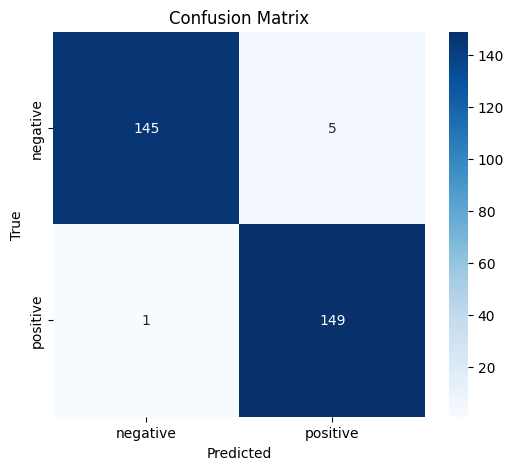

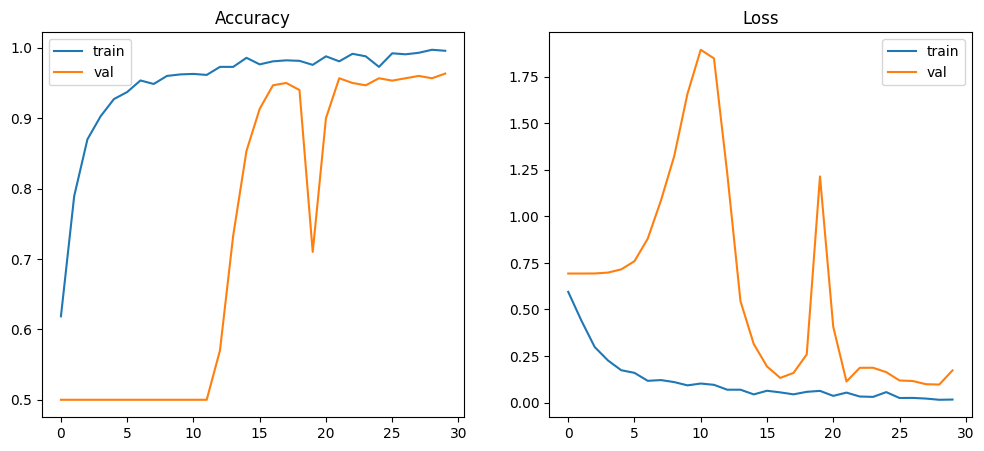

In [7]:

import numpy as np
from sklearn.metrics import confusion_matrix, precision_score, recall_score, f1_score, classification_report
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf

test_logits = model.predict(test_generator, verbose=1)
test_probs = tf.nn.sigmoid(test_logits).numpy().flatten()
test_preds = (test_probs > 0.5).astype(int)
test_labels = test_generator.labels

acc = np.mean(test_preds == test_labels)
precision = precision_score(test_labels, test_preds)
recall = recall_score(test_labels, test_preds)
f1 = f1_score(test_labels, test_preds)
cm = confusion_matrix(test_labels, test_preds)

print(f"Test accuracy: {acc:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1 score: {f1:.4f}")
print('\nClassification report:\n', classification_report(test_labels, test_preds))

plt.figure(figsize=(6,5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=list(test_generator.class_indices.keys()),
            yticklabels=list(test_generator.class_indices.keys()))
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

plt.figure(figsize=(12,5))
plt.subplot(1,2,1)
plt.plot(history.history['accuracy'], label='train')
plt.plot(history.history['val_accuracy'], label='val')
plt.title('Accuracy')
plt.legend()
plt.subplot(1,2,2)
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='val')
plt.title('Loss')
plt.legend()
plt.show()


## Video analysis

In [8]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing import image
from tqdm import tqdm
import time

def analyze_video_with_confidence(video_path, model, threshold=0.5, frame_step=5):
    cap = cv2.VideoCapture(video_path)
    fps = cap.get(cv2.CAP_PROP_FPS)
    frame_count = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))
    duration = frame_count / fps

    confidences = []
    times = []

    frame_id = 0
    while True:
        ret, frame = cap.read()
        if not ret:
            break
        if frame_id % frame_step != 0:
            frame_id += 1
            continue
        
        img = cv2.resize(frame, (300, 300))
        img = img.astype('float32') / 255.0
        img = np.expand_dims(img, axis=0)
        
        conf = model.predict(img, verbose=0)[0][0]
        confidences.append(conf)
        times.append(frame_id / fps)
        
        frame_id += 1
    
    cap.release()

    plt.figure(figsize=(12, 4))
    plt.plot(times, confidences, label="Confidence (BMW logo)")
    plt.axhline(threshold, color='r', linestyle='--', label=f'Threshold ({threshold})')
    plt.xlabel("time (s)")
    plt.ylabel("Confidence")
    plt.title("Per frame ")
    plt.legend()
    plt.grid(True)
    plt.show()

start_step = time.time()
analyze_video_with_confidence(video_path, model, threshold=0.5, frame_step=5)
end_step = time.time()
print(f"Elapsed time for step analysis (frame_step=5): {end_step - start_step:.2f} s")

start_full = time.time()
analyze_video_with_confidence(video_path, model, threshold=0.5, frame_step=1)
end_full = time.time()
print(f"Elapsed time for full frame analysis (frame_step=1): {end_full - start_full:.2f} s")

speedup = (end_full - start_full) / (end_step - start_step)
print(f"Speed-up factor: {speedup:.2f}x")

ValueError: Input 0 of layer "functional" is incompatible with the layer: expected shape=(None, 256, 256, 3), found shape=(1, 300, 300, 3)

## Check against random image slice

In [ ]:
import random
import matplotlib.pyplot as plt

def test_random_images(model, test_dir, class_names, N=8):
    all_images = []
    for cls in class_names:
        path = os.path.join(test_dir, cls)
        files = [os.path.join(path, f) for f in os.listdir(path) if f.lower().endswith(('jpg','png','jpeg'))]
        all_images += files

    random.shuffle(all_images)
    sample_images = all_images[:N]

    plt.figure(figsize=(16, 8))
    for i, img_path in enumerate(sample_images):
        img = image.load_img(img_path, target_size=(300, 300))
        x = image.img_to_array(img)
        x = np.expand_dims(x, axis=0) / 255.0
        pred = model.predict(x, verbose=0)[0][0]
        label = "BMW" if pred >= 0.5 else "no BMW"
        color = "green" if label == "BMW" else "red"

        plt.subplot(2, N//2, i+1)
        plt.imshow(img)
        plt.title(f"{label}\n({pred:.2f})", color=color)
        plt.axis('off')

    plt.suptitle("Results", fontsize=16)
    plt.tight_layout()
    plt.show()
test_random_images(model, dataset_dir+"/test", ["negative","positive"], N=8)

# 